<a href="https://colab.research.google.com/github/hammaad2002/AdversarialAttack/blob/main/cw_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install python-Levenshtein
!git clone https://github.com/hammaad2002/CRDNN_Model.git
!pip install colorama

In [ ]:
# Importing necessary modules/packages
import torchaudio
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from tqdm import tqdm
import Levenshtein
from colorama import Fore
from tqdm.autonotebook import tqdm

In [ ]:
# Class for generating adversarial attack 
class AdversarialAttackWav2vec2():

  def __init__(self, model, device):
    # Constructor method
    self.model = model
    self.device = device

  def is_successful_attack(self, adversarial_audio: torch.Tensor, target_transcription: str, threshold: float = 0.5) -> bool:
    # Forward pass
    predicted_transcription = output, _ = self.model(adversarial_audio.to(self.device))
    
    # Return the WER using Levenshtein formula 
    return Levenshtein.ratio(predicted_transcription, target_transcription) < threshold
  
  def encode_transcription(self, transcription):
    # Define the dictionary
    dictionary = {'-': 0, '|': 1, 'E': 2, 'T': 3, 'A': 4, 'O': 5, 'N': 6, 'I': 7, 'H': 8, 'S': 9, 'R': 10, 'D': 11, 'L': 12, 'U': 13, 'M': 14, 'W': 15, 'C': 16, 'F': 17, 'G': 18, 'Y': 19, 'P': 20, 'B': 21, 'V': 22, 'K': 23, "'": 24, 'X': 25, 'J': 26, 'Q': 27, 'Z': 28}

    # Convert transcription string to list of characters
    chars = list(transcription)

    # Encode each character using the dictionary
    encoded_chars = [dictionary[char] for char in chars]

    # Concatenate the encoded characters to form the final encoded transcription
    encoded_transcription = torch.tensor(encoded_chars)

    # Returning the encoded transcription
    return encoded_transcription
  
  def CW_ASR(self, input_audio: np.ndarray, target_transcription: str,
                         eps: float = 0.0, c: float = 1e-4, learning_rate: float = 0.01,
                         max_iter: int = 1000, decrease_factor_eps: float = 0.8,
                         num_iter_decrease_eps: int = 10, opt: str = None) -> np.ndarray:
    # Convert the input audio to a PyTorch tensor
    input_audio = torch.from_numpy(input_audio).to(self.device).float()
    input_audio.requires_grad_()
    input_audio_orig = input_audio.clone()
    
    # Encode the target transcription
    encoded_transcription = self.encode_transcription(target_transcription)
    
    # Convert the target transcription to a PyTorch tensor
    target = torch.from_numpy(np.array(encoded_transcription)).to(self.device).long()
    
    if opt == "Adam":
    # Define the optimizer
        optimizer = torch.optim.Adam([input_audio], lr=learning_rate)
    else:
        optimizer = torch.optim.SGD([input_audio], lr=learning_rate)
    # Run the optimization loop
    successful_attack = False
    num_successful_attacks = 0
    
    for i in tqdm(range(max_iter), colour="red"):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the model’s prediction
        output, _ = self.model(input_audio)
        output = F.log_softmax(output, dim=-1)
        
        # Compute the CTC loss function
        output_lengths = torch.tensor([output.shape[1]], dtype=torch.long).to(self.device)
        output = output.transpose(0, 1)
        target_lengths = torch.tensor([len(encoded_transcription)], dtype=torch.long).to(self.device)
        loss_classifier = F.ctc_loss(output, target, output_lengths, target_lengths, blank=0, reduction='mean')
        
        # Regularization term to minimize the perturbation
        loss_regularizer = c * torch.norm(input_audio - input_audio_orig)
        
        # Combine the losses and compute gradients
        loss = loss_classifier + loss_regularizer
        loss.backward()
        
        # Update the input audio with gradients
        optimizer.step()
        
        # Project the perturbation onto the epsilon ball and clip to audio range using PGD technique which author used in his paper
        perturbation = input_audio - input_audio_orig
        perturbation = torch.clamp(perturbation, -eps, eps)
        input_audio.data = torch.clamp(input_audio_orig + perturbation, -1, 1)
        
        # Check if the attack is successful (for targetted attacks only)
        if self.is_successful_attack(input_audio, target_transcription):
            num_successful_attacks += 1
            if num_successful_attacks >= num_iter_decrease_eps:
                successful_attack = True
                eps *= decrease_factor_eps
                num_successful_attacks = 0
            else:
                successful_attack = False
                num_successful_attacks = 0
        if successful_attack and eps <= 0:
            break
    
    # Return the adversarial audio
    return input_audio.detach().cpu().numpy()

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [ ]:
# Loading the model from torchaudio model hub
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model()

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

In [ ]:
# Checking the device available during the current environment (CUDA is recommended!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Initializing the class of Adversarial Attack
attack = AdversarialAttackWav2vec2(model, device)

# **Author's parameter of CW attack**

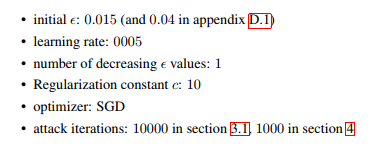

In [ ]:
# Loading the audio
input_audio, sample_rate = torchaudio.load('/kaggle/working/CRDNN_Model/AudioSamplesASR/spk1_snt1.wav')

# Converting the audio to numpy array
input_audio = input_audio.numpy()

# My target
target_transcription = 'THE MAN ALMOST KILL THE BIG CAMEL'

In [ ]:
# CW attack function
adv_audio = attack.CW_ASR( 
    input_audio, 
    list(target_transcription.upper().replace(" ","|")), 
    c=10, 
    learning_rate=0.005,
    eps = 0.015, 
    max_iter = 10000, 
    decrease_factor_eps = 1,
    num_iter_decrease_eps = 10,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Saving the audio
torchaudio.save('/kaggle/working/myaudio.wav', torch.from_numpy(adv_audio), sample_rate)

In [ ]:
from IPython.display import Audio
Audio('/kaggle/working/myaudio.wav')                               # Perturbed

In [ ]:
Audio('/kaggle/working/CRDNN_Model/AudioSamplesASR/spk1_snt1.wav') # Clean

In [ ]:
# input_audio1, sample_rate1 = torchaudio.load('/content/CRDNN_Model/AudioSamplesASR/spk1_snt1.wav')
# input_audio2, sample_rate2 = torchaudio.load('/content/myaudio.wav')
# tempp = input_audio1- input_audio2
# print(np.sum(tempp.numpy()))

In [ ]:
# Original clean audio
input_audio, sample_rate = torchaudio.load('/kaggle/working/CRDNN_Model/AudioSamplesASR/spk1_snt1.wav')
# Perturbed crafted audio
waveform, sample_rate = torchaudio.load('/kaggle/working/myaudio.wav') 

In [ ]:
waveform = waveform.to(device)       
input_audio = input_audio.to(device) 

In [ ]:
# Forward pass the data through the model
emission1, _1 = model(waveform)       # Perturbed
emission2, _2 = model(input_audio)    # Clean

# Decoding the model's output
decoder = GreedyCTCDecoder(labels = bundle.get_labels())
transcript1 = decoder(emission1[0])   # Perturbed
transcript2 = decoder(emission2[0])   # Clean
print("Assigned Targetted transcription:  ",target_transcription.replace("|"," "))
print("Perturbed Targetted transcription: ",transcript1.replace("|"," "))
print("Clean original transcription:      ",transcript2.replace("|"," "))

Assigned Targetted transcription:   THE MAN ALMOST KILL THE BIG CAMEL
Perturbed Targetted transcription:  THE MAN ALMOST KILL THE BIG CAMEL
Clean original transcription:       HE CHILD ALMOST HURT THE SMALL DOG 


# **COMPARISON WITH AUTHOR'S GENERATED EXAMPLES**

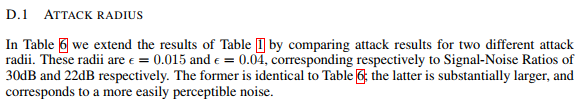

In [ ]:
%%capture
!pip install datasets

In [ ]:
from datasets import load_dataset
import IPython.display as ipd

In [ ]:
%%capture
librispeech_adv_eval = load_dataset("RaphaelOlivier/librispeech_asr_adversarial", "adv", split="adv_0.015")
temp1 = librispeech_adv_eval[4]['audio']['array'] #0.015

In [ ]:
from IPython.display import Audio
Audio('/kaggle/working/myaudio.wav')              # Our Example

In [ ]:
ipd.display(ipd.Audio(temp1, rate=16000))  # Author's Example (0.015 or 30dB example)

In [ ]:
#creating function of metric
def Metricsnr(original, noisy):
    original_power = 20 * np.log10(np.mean(original ** 2))
    noise_power = 20 * np.log10(np.mean((original - noisy) ** 2))
    snr = noise_power - original_power
    return snr

In [ ]:
SNR = Metricsnr(input_audio.cpu().numpy(), waveform.cpu().numpy())
print("The SNR of signal is", SNR)

The SNR of signal is -15.667762756347656
